# **Estação metereológica CRHEA**

*   **Nome:** CRHEA
*   **Tipo:** Meteorológica
*   **Data da instalação:**
*   **Local da instalação:** CRHEA
*   **Bacia:**
*   **Latitude:** 22 01'22"S (-22.022777777778)
*   **Longitude:** 43 57'38"W (-43.960555555556)
*   **Altitude:** 733m
*   **Cobertura do solo:** Pasto



## 1. Coleta de Dados

Esse dataset possui as leituras automáticas realizadas no período de **01/01/1980 à 30/09/2025**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importação de bibliotecas Python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller

# Caminho para o arquivo no Google Drive
caminho_arquivo = "/content/drive/MyDrive/datasets/CRHEA/dados_crhea_agregados_mensalmente_011980_a_092025.csv"

# Lendo o conjunto de dados
df = pd.read_csv(caminho_arquivo, parse_dates=True, index_col=0)

# Criando variáveis de data, precipitação e temperatura média
coluna_data = 'data'
coluna_precipitacao = 'rain'
coluna_temperatura_media = 'tmean'

# Ordena por data
df = df.sort_values(coluna_data)

df

,rain,tmean
data,,
1980-01-01,131.6,22.635484
1980-02-01,263.0,23.268966
1980-03-01,90.2,23.851613
1980-04-01,133.4,21.406667
1980-05-01,11.4,19.470968
...,...,...
2025-05-01,3.6,20.877419
2025-06-01,53.0,19.728544
2025-07-01,11.0,18.451613


# Teste de Estacionariedade (Teste de Dickey-Fuller Aumentado - ADF)
O VAR requer que as séries sejam estacionárias.

In [ ]:
def check_stationarity(series, name):
    """Executa o teste ADF e retorna o p-valor e o resultado."""
    result = adfuller(series, autolag='AIC')
    is_stationary = result[1] < 0.05
    print(f"  - {name}: p-valor = {result[1]:.4f} -> Estacionário: {is_stationary}")
    return is_stationary

print("## 📊 Verificação de Estacionariedade (Teste ADF)")
is_rain_stationary = check_stationarity(df[coluna_precipitacao], "Precipitação Mensal")
is_tmean_stationary = check_stationarity(df[coluna_temperatura_media], "Temperatura Média Mensal")

# --- Diferenciação se Necessário (Para alcançar a estacionariedade) ---
if not is_rain_stationary or not is_tmean_stationary:
    print("\n⚠️ Uma ou ambas as séries NÃO são estacionárias. Aplicando Diferenciação (Ordem 1).")
    model_data = df.diff().dropna()
    print("\n✅ Verificação de Estacionariedade após Diferenciação:")
    check_stationarity(model_data[coluna_precipitacao], "Precipitação Mensal (Diferenciada)")
    check_stationarity(model_data[coluna_temperatura_media], "Temperatura Média Mensal (Diferenciada)")
else:
    model_data = df.copy()

## 📊 Verificação de Estacionariedade (Teste ADF)
  - Precipitação Mensal: p-valor = 0.0000 -> Estacionário: True
  - Temperatura Média Mensal: p-valor = 0.1957 -> Estacionário: False

⚠️ Uma ou ambas as séries NÃO são estacionárias. Aplicando Diferenciação (Ordem 1).

✅ Verificação de Estacionariedade após Diferenciação:
  - Precipitação Mensal (Diferenciada): p-valor = 0.0000 -> Estacionário: True
  - Temperatura Média Mensal (Diferenciada): p-valor = 0.0000 -> Estacionário: True


# Modelagem e Previsão VAR

Para a previsão de 5 anos, precisamos de $5 \times 12 = 60$ passos à frente.

In [ ]:
# Determinar a ordem ideal do VAR (p).
max_lags = 24 # Testar defasagens de até 2 anos
var_model = VAR(model_data)

# Seleciona o número ideal de defasagens 'p' que minimiza o BIC (Bayesian Information Criterion)
lag_order = var_model.select_order(maxlags=max_lags).bic
if lag_order == 0:
    lag_order = 1 # Garante pelo menos uma defasagem

# Treinar o modelo VAR
var_model_fitted = var_model.fit(lag_order)

# Previsão de 5 anos (60 meses)
forecast_steps = 60
last_values = model_data.values[-lag_order:]
forecast_diff = var_model_fitted.forecast(y=last_values, steps=forecast_steps)

# Organizar o resultado da previsão (Dados Diferenciados)
forecast_diff_df = pd.DataFrame(forecast_diff, columns=model_data.columns)

# Reverter a Diferenciação (Necessário para obter valores reais) ---
# O forecast reverte-se somando o último valor real da série original.
last_original_values = df.iloc[-1]
forecast_df = (forecast_diff_df.cumsum() + last_original_values)

# Criar o índice de tempo para a previsão
last_date = df.index[-1]
# O índice começa no mês seguinte ao último dado
forecast_index = pd.date_range(start=last_date, periods=forecast_steps + 1, freq='M')[1:]
forecast_df.index = forecast_index

# Arredondar e garantir que a precipitação não seja negativa
forecast_df = forecast_df.round(2)
forecast_df[coluna_precipitacao] = forecast_df[coluna_precipitacao].clip(lower=0)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/tmp/ipython-input-490013218.py:29: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=last_date, periods=forecast_steps + 1, freq='M')[1:]


# 7. Visualizar os resultados

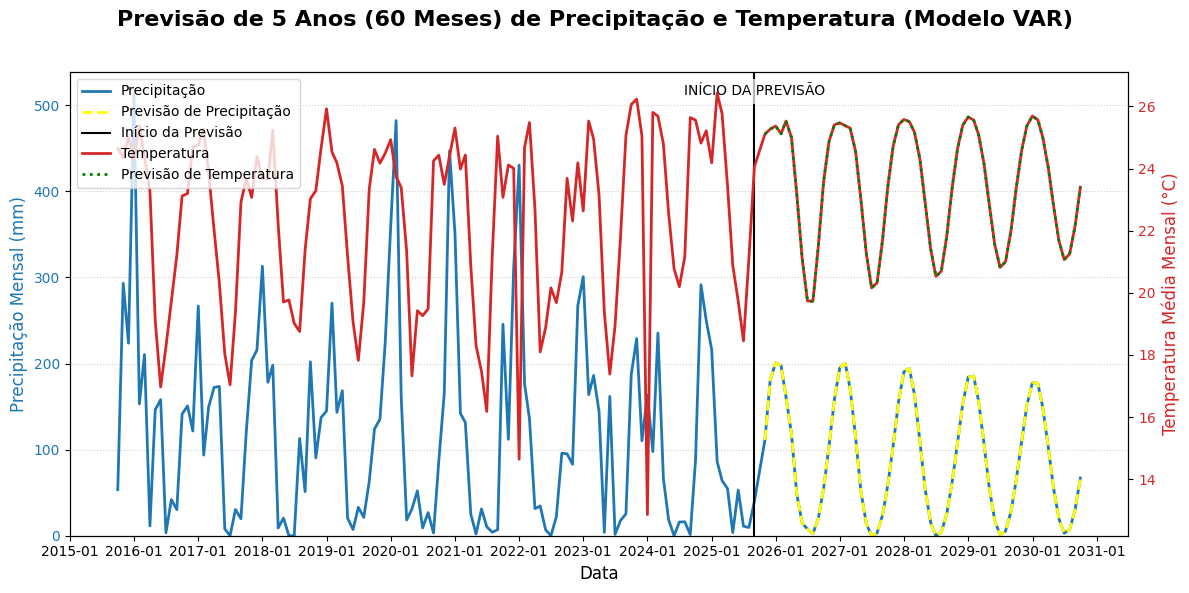

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- Configuração dos dados para o gráfico ---

# Concatenar dados históricos (últimos 3 anos, por exemplo) com a previsão
# Usando o DataFrame data_mensal original e o forecast_df gerado
n_history = 120 # 36 meses (3 anos) de histórico para comparação
plot_data = pd.concat([df.iloc[-n_history:], forecast_df])

# Definir a data onde começa a previsão (linha vertical de separação)
forecast_start_date = df.index[-1]

# --- Criação do Gráfico com Eixos Secundários (Two Y-Axes) ---

fig, ax1 = plt.subplots(figsize=(12, 6))

# Título Principal
fig.suptitle('Previsão de 5 Anos (60 Meses) de Precipitação e Temperatura (Modelo VAR)',
             fontsize=16, weight='bold')

# --- Eixo Y Primário: Precipitação (rain) ---
color_rain = 'tab:blue'
ax1.set_xlabel('Data', fontsize=12)
ax1.set_ylabel('Precipitação Mensal (mm)', color=color_rain, fontsize=12)

# Plotar Precipitação (Histórico e Previsão)
ax1.plot(plot_data.index, plot_data[coluna_precipitacao], color=color_rain, label='Precipitação', linewidth=2)
# Destacar a previsão com linha tracejada
ax1.plot(forecast_df.index, forecast_df[coluna_precipitacao], color='yellow', linestyle='--', linewidth=2, label='Previsão de Precipitação')
ax1.tick_params(axis='y', labelcolor=color_rain)
ax1.grid(axis='y', linestyle=':', alpha=0.6)
ax1.set_ylim(bottom=0) # Precipitação deve começar em 0

# --- Eixo Y Secundário: Temperatura (tmean) ---
# Cria um segundo eixo que compartilha o mesmo eixo X (ax1)
ax2 = ax1.twinx()
color_tmean = 'tab:red'
ax2.set_ylabel('Temperatura Média Mensal (°C)', color=color_tmean, fontsize=12)

# Plotar Temperatura (Histórico e Previsão)
ax2.plot(plot_data.index, plot_data[coluna_temperatura_media], color=color_tmean, label='Temperatura', linewidth=2)
# Destacar a previsão com linha tracejada
ax2.plot(forecast_df.index, forecast_df[coluna_temperatura_media], color='green', linestyle=':', linewidth=2, label='Previsão de Temperatura')
ax2.tick_params(axis='y', labelcolor=color_tmean)

# --- Linha de Separação (Histórico vs. Previsão) ---
ax1.axvline(x=forecast_start_date, color='black', linestyle='-', linewidth=1.5, label='Início da Previsão')
ax1.text(forecast_start_date, ax1.get_ylim()[1] * 0.95, 'INÍCIO DA PREVISÃO',
         rotation=0, ha='center', color='black', fontsize=10, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

# --- Formatação do Eixo X ---
# Define o formato e a frequência dos ticks no eixo X
formatter = mdates.DateFormatter('%Y-%m')
ax1.xaxis.set_major_formatter(formatter)
ax1.xaxis.set_major_locator(mdates.YearLocator(1)) # Ticks a cada ano
plt.xticks(rotation=45, ha='right')

# Adicionar legendas
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left', frameon=True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


## 📈 Gráfico da Previsão VAR Usando plot_forecast (Dados Diferenciados)


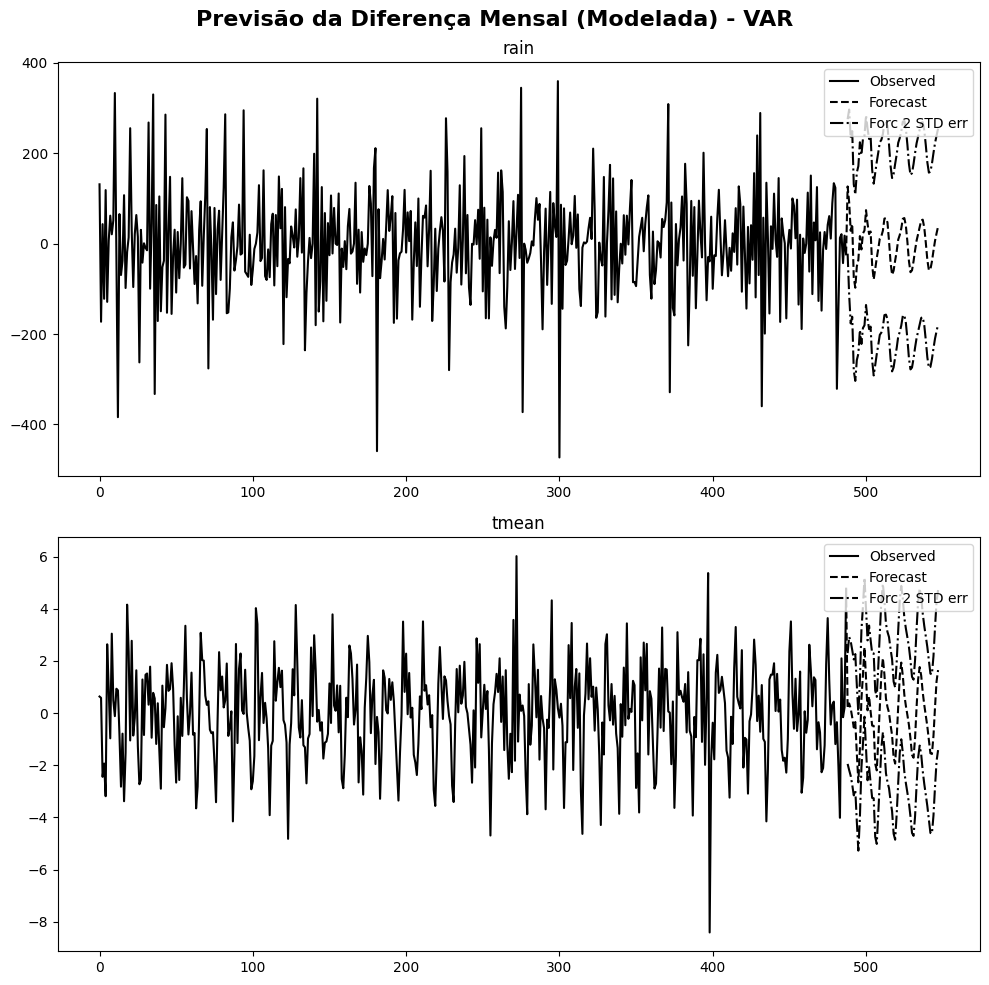

In [ ]:
n_test = 60
train_data_diff = model_data.iloc[:-n_test]
lag_order = 17 # Ordem de defasagem determinada anteriormente

# --- Ajuste do Modelo de Treinamento ---
var_model_train = VAR(train_data_diff)
var_model_fitted_train = var_model_train.fit(lag_order)

# --- Uso da função plot_forecast ---
print("## 📈 Gráfico da Previsão VAR Usando plot_forecast (Dados Diferenciados)")

# O número de passos a prever é 'n_test' (60 meses)
fig = var_model_fitted_train.plot_forecast(n_test)

# Customização do gráfico gerado pelo plot_forecast
fig.suptitle('Previsão da Diferença Mensal (Modelada) - VAR', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

# Avaliação dos resultados

#Preparação dos Dados e Divisão Treino/Teste

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Retomar a última versão do DataFrame agregada mensalmente e diferenciada,
# que foi usada para treinar o modelo na etapa anterior.
# Assumimos que 'model_data' está diferenciado (data_mensal.diff().dropna())
# e 'data_mensal' é a série original mensal.

# Divisão dos dados em treino e teste (usando 60 meses como teste)
n_test = 60
train_data_diff = model_data.iloc[:-n_test]
test_data_diff = model_data.iloc[-n_test:]

# Último valor do conjunto de treino da SÉRIE ORIGINAL (necessário para reverter a diferenciação)
last_original_train = df.iloc[-n_test-1]

# 2. Re-treinar o Modelo VAR (Apenas com o conjunto de Treino)
# Usando a ordem de defasagem (lag_order) de 17 encontrada anteriormente.
lag_order = 17
var_model_train = VAR(train_data_diff)
var_model_fitted_train = var_model_train.fit(lag_order)

# 3. Gerar a Previsão (Out-of-Sample)
# Obter os últimos 'lag_order' valores do conjunto de treino diferenciado
last_values_diff = train_data_diff.values[-lag_order:]

# Prever os 60 meses (n_test)
forecast_diff_test = var_model_fitted_train.forecast(y=last_values_diff, steps=n_test)
forecast_diff_df_test = pd.DataFrame(forecast_diff_test, columns=test_data_diff.columns)
forecast_diff_df_test.index = test_data_diff.index # Sincronizar o índice de data

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


#Reverter a Diferenciação
O modelo previu a diferença (taxa de variação). Para comparar com os dados reais de teste, precisamos reverter esse processo para obter os valores mensais originais.

In [ ]:
# Reverter a diferenciação para obter os valores originais previstos
# forecast_original = forecast_diff_df_test.cumsum() + last_original_train
forecast_original = pd.DataFrame(index=forecast_diff_df_test.index, columns=forecast_diff_df_test.columns)

# Reversão iterativa da diferenciação
prev_rain = last_original_train[coluna_precipitacao]
prev_tmean = last_original_train[coluna_temperatura_media]

for i in range(n_test):
    # Valor previsto = Diferença prevista + Valor anterior original
    forecast_original.loc[forecast_diff_df_test.index[i], coluna_precipitacao] = forecast_diff_df_test.iloc[i][coluna_precipitacao] + prev_rain
    forecast_original.loc[forecast_diff_df_test.index[i], coluna_temperatura_media] = forecast_diff_df_test.iloc[i][coluna_temperatura_media] + prev_tmean

    # Atualiza o valor anterior para o próximo passo (autocorregressivo)
    prev_rain = forecast_original.loc[forecast_diff_df_test.index[i], coluna_precipitacao]
    prev_tmean = forecast_original.loc[forecast_diff_df_test.index[i], coluna_temperatura_media]

# Garante que a precipitação não seja negativa
forecast_original[coluna_precipitacao] = forecast_original[coluna_precipitacao].clip(lower=0)

# Cálculo das Métricas de Erro

In [ ]:
# Valores reais (target)
actual_rain = df[coluna_precipitacao].iloc[-n_test:]
actual_tmean = df[coluna_temperatura_media].iloc[-n_test:]

# Valores previstos
pred_rain = forecast_original[coluna_precipitacao]
pred_tmean = forecast_original[coluna_temperatura_media]

def calculate_metrics(actual, predicted, name):
    """Calcula e retorna RMSE, MAE e MAPE."""
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)

    # Cálculo do MAPE: Filtra divisões por zero e NaNs, comum em precipitação com zeros
    valid_indices = (actual != 0)
    mape = np.mean(np.abs((actual[valid_indices] - predicted[valid_indices]) / actual[valid_indices])) * 100

    return {
        'Variável': name,
        'RMSE': f'{rmse:.2f}',
        'MAE': f'{mae:.2f}',
        'MAPE': f'{mape:.2f}% (excl. zeros)'
    }

metrics_rain = calculate_metrics(actual_rain, pred_rain, 'Precipitação (rain_mensal)')
metrics_tmean = calculate_metrics(actual_tmean, pred_tmean, 'Temperatura (tmean_mensal)')

metrics_df = pd.DataFrame([metrics_rain, metrics_tmean]).set_index('Variável')

print("\n## 🎯 Avaliação Preditiva do Modelo VAR (Out-of-Sample - 60 Meses)")
print(metrics_df)


## 🎯 Avaliação Preditiva do Modelo VAR (Out-of-Sample - 60 Meses)
                             RMSE    MAE                   MAPE
Variável                                                       
Precipitação (rain_mensal)  69.15  56.92  370.59% (excl. zeros)
Temperatura (tmean_mensal)   2.49   1.53    7.85% (excl. zeros)
